#**Task 0**

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np
from tensorflow.keras import layers

# To make this notebook's output stable across runs
np.random.seed(77)
tf.random.set_seed(88)

In [2]:
print(tf.__version__)

2.5.0


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'README', 'test', 'imdbEr.txt']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'urls_unsup.txt',
 'pos',
 'urls_pos.txt',
 'unsupBow.feat',
 'unsup',
 'urls_neg.txt',
 'neg']

In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    seed=seed)



Found 25000 files belonging to 2 classes.


In [8]:
#782 batches, 781*32+ 24=25,000
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [9]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [10]:
max_features = 10000
sequence_length = 250
embedding_dim=128

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [11]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [12]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [13]:
#100% training dataset :25,000
train_ds = raw_train_ds.map(vectorize_text) 

#100% testing dataset: 25,000
test_ds = raw_test_ds.map(vectorize_text) 

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, 16),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [17]:
epochs = 10
history2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs)

Epoch 1/10
782/782 [==============================] - 16s 19ms/step - loss: 0.6508 - binary_accuracy: 0.7060 - val_loss: 0.5850 - val_binary_accuracy: 0.7780
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.5076 - binary_accuracy: 0.8188 - val_loss: 0.4614 - val_binary_accuracy: 0.8282
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.4030 - binary_accuracy: 0.8575 - val_loss: 0.3946 - val_binary_accuracy: 0.8491
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3447 - binary_accuracy: 0.8742 - val_loss: 0.3589 - val_binary_accuracy: 0.8581
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3084 - binary_accuracy: 0.8858 - val_loss: 0.3375 - val_binary_accuracy: 0.8656
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2818 - binary_accuracy: 0.8944 - val_loss: 0.3239 - val_binary_accuracy: 0.8696
Epoch 7/10
782/782 [==============================] - 5s 6ms/s

In [18]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 2ms/step - loss: 0.3050 - binary_accuracy: 0.8752
Loss:  0.3049754500389099
Accuracy:  0.8752400279045105


In [19]:
history_dict = history2.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

# **Task1**

In [20]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# The Conv1D layer
x = layers.Conv1D(64, kernel_size=(5//2)+5, padding="valid", activation="relu", strides=3)(x)

# Global max pooling
x = layers.GlobalMaxPooling1D()(x)

# Adding the hidden layer:

x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# With a sigmoid function, it hekps to get a range of value between 0 and 1
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

CNN1 = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
CNN1.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
CNN1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          57408     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0     

In [22]:
epochs = 10

CNN1.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/10
782/782 [==============================] - 17s 19ms/step - loss: 0.4976 - accuracy: 0.7319 - val_loss: 0.3536 - val_accuracy: 0.8432
Epoch 2/10
782/782 [==============================] - 15s 19ms/step - loss: 0.2713 - accuracy: 0.8912 - val_loss: 0.3313 - val_accuracy: 0.8582
Epoch 3/10
782/782 [==============================] - 15s 19ms/step - loss: 0.1759 - accuracy: 0.9334 - val_loss: 0.3567 - val_accuracy: 0.8627
Epoch 4/10
782/782 [==============================] - 15s 19ms/step - loss: 0.1140 - accuracy: 0.9588 - val_loss: 0.4101 - val_accuracy: 0.8588
Epoch 5/10
782/782 [==============================] - 15s 19ms/step - loss: 0.0822 - accuracy: 0.9711 - val_loss: 0.4615 - val_accuracy: 0.8598
Epoch 6/10
782/782 [==============================] - 14s 18ms/step - loss: 0.0581 - accuracy: 0.9791 - val_loss: 0.5490 - val_accuracy: 0.8605
Epoch 7/10
782/782 [==============================] - 14s 18ms/step - loss: 0.0545 - accuracy: 0.9798 - val_loss: 0.5742 - val_accuracy:

We can observe the trend between origin net and CNN1. Executing 10 times, the history performance of accuracy in origin net is over than 85%. On the other hand, the CNN1 only closes to 86%.  

From the history that we get, we can know that the origin net is better than CNN1 model becuase it includes the Global Average Pooling layer rather than equiping the Conv1D and Global Max pooling layer.

In [23]:
#Using evaluate function to get the final result of model.
CNN1.evaluate(test_ds)

782/782 [==============================] - 2s 3ms/step - loss: 0.6566 - accuracy: 0.8583


[0.6566087007522583, 0.8582800030708313]

# **Task 2**

In [24]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# First Conv1D layer 
x = layers.Conv1D(64, kernel_size=(5//2)+5-1, padding="valid", activation="relu", strides=3)(x)

# Second Conv1D layer
x = layers.Conv1D(128, kernel_size=(5//2)+5-1, padding="valid", activation="relu", strides=3)(x)

# Global max pooling
x = layers.GlobalMaxPooling1D()(x)


# Adding the hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# With a sigmoid function, it hekps to get a range of value between 0 and 1
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

CNN2 = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
CNN2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [25]:
CNN2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          49216     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         49280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1651

In [26]:
#Learning and recording 10 times in the performance of model "CNN2". 
epochs = 10

# Fit the model using the train and test datasets.
CNN2.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/10
782/782 [==============================] - 17s 21ms/step - loss: 0.4982 - accuracy: 0.7181 - val_loss: 0.3865 - val_accuracy: 0.8220
Epoch 2/10
782/782 [==============================] - 17s 21ms/step - loss: 0.2574 - accuracy: 0.8978 - val_loss: 0.3585 - val_accuracy: 0.8506
Epoch 3/10
782/782 [==============================] - 16s 20ms/step - loss: 0.1619 - accuracy: 0.9392 - val_loss: 0.4165 - val_accuracy: 0.8487
Epoch 4/10
782/782 [==============================] - 16s 20ms/step - loss: 0.1093 - accuracy: 0.9606 - val_loss: 0.4801 - val_accuracy: 0.8460
Epoch 5/10
782/782 [==============================] - 16s 20ms/step - loss: 0.0679 - accuracy: 0.9756 - val_loss: 0.6947 - val_accuracy: 0.8445
Epoch 6/10
782/782 [==============================] - 16s 20ms/step - loss: 0.0499 - accuracy: 0.9832 - val_loss: 0.7037 - val_accuracy: 0.8486
Epoch 7/10
782/782 [==============================] - 16s 20ms/step - loss: 0.0390 - accuracy: 0.9868 - val_loss: 0.7526 - val_accuracy:

Based on the history performance of accuracy in CNN2, it decreases roughly 1% of accuracy in the experiment. While adding a new Conv1D and decreasing the kernel size, it shows not a significant improvement.

In conclusion, if the result of performance is not satisfy for data analyst, we need to based on different situations to adjust the number of layer and adjusting the parameter are the good method to reach our goals.

In [27]:
#Using evaluate function to get the final result of model.
CNN2.evaluate(test_ds)

782/782 [==============================] - 3s 3ms/step - loss: 0.8383 - accuracy: 0.8484


[0.8382877111434937, 0.848360002040863]

# **Task3**

In [28]:
# 20% of training dataset in 157 items with 32 batch size

raw_train_ds_20 = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.8,
    subset='training', 
    seed=seed)

train_text_20 = raw_train_ds_20.map(lambda x, y: x)
vectorize_layer.adapt(train_text_20)

train_ds_20 = raw_train_ds_20.map(vectorize_text) 

train_ds_20 = train_ds_20.cache().prefetch(buffer_size=AUTOTUNE)


# 40% of training dataset in 313 items with 32 batch size

raw_train_ds_40 = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    validation_split=0.6,
    batch_size=batch_size, 
    subset='training',
    seed=seed)

train_text_40 = raw_train_ds_40.map(lambda x, y: x)
vectorize_layer.adapt(train_text_40)

train_ds_40 = raw_train_ds_40.map(vectorize_text) 

train_ds_40 = train_ds_40.cache().prefetch(buffer_size=AUTOTUNE)

# 60% of training dataset in 469 items with 32 batch size
raw_train_ds_60 = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    validation_split=0.4,
    batch_size=batch_size, 
    subset='training',
    seed=seed)

train_text_60 = raw_train_ds_40.map(lambda x, y: x)
vectorize_layer.adapt(train_text_60)

train_ds_60 = raw_train_ds_60.map(vectorize_text) 

train_ds_60 = train_ds_60.cache().prefetch(buffer_size=AUTOTUNE)

# 80% of training dataset in 625 items with 32 batch size
raw_train_ds_80 = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    validation_split=0.2,
    batch_size=batch_size, 
    subset='training',
    seed=seed)

train_text_80 = raw_train_ds_80.map(lambda x, y: x)
vectorize_layer.adapt(train_text_80)

train_ds_80 = raw_train_ds_80.map(vectorize_text) 

train_ds_80 = train_ds_80.cache().prefetch(buffer_size=AUTOTUNE)

# 100% of training dataset in 782 items with 32 batch size
train_ds_100=train_ds

Found 25000 files belonging to 2 classes.
Using 5000 files for training.
Found 25000 files belonging to 2 classes.
Using 10000 files for training.
Found 25000 files belonging to 2 classes.
Using 15000 files for training.
Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Comparing with the performance between CNN1 and CNN2 model, choosing the CNN1 as the better model to train the different subsets from original data. 

In [29]:
from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# First Conv1D layer 
x = layers.Conv1D(64, kernel_size=(5//2)+5, padding="valid", activation="relu", strides=3)(x)

# Global max pooling
x = layers.GlobalMaxPooling1D()(x)

# I add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

CNNbest = tf.keras.Model(inputs, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
CNNbest.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [30]:
epochs = 10

# Fit the model using the train and test datasets.
history_20=CNNbest.fit(train_ds_20, validation_data=test_ds, epochs=epochs)
CNNbest.evaluate(test_ds)
history_20_dict = history_20.history
history_20_dict.keys()

#------------------------------------------------------------------#

history_40=CNNbest.fit(train_ds_40, validation_data=test_ds, epochs=epochs)
CNNbest.evaluate(test_ds)
history_40_dict = history_40.history
history_40_dict.keys()

#------------------------------------------------------------------#

history_60=CNNbest.fit(train_ds_60, validation_data=test_ds, epochs=epochs)
CNNbest.evaluate(test_ds)
history_60_dict = history_60.history
history_60_dict.keys()

#------------------------------------------------------------------#

history_80=CNNbest.fit(train_ds_80, validation_data=test_ds, epochs=epochs)
CNNbest.evaluate(test_ds)
history_80_dict = history_80.history
history_80_dict.keys()
#------------------------------------------------------------------#

history_100=CNNbest.fit(train_ds_100, validation_data=test_ds, epochs=epochs)
CNNbest.evaluate(test_ds)
history_100_dict = history_100.history
history_100_dict.keys()

Epoch 1/10
157/157 [==============================] - 6s 33ms/step - loss: 0.6920 - accuracy: 0.5202 - val_loss: 0.6825 - val_accuracy: 0.6229
Epoch 2/10
157/157 [==============================] - 4s 26ms/step - loss: 0.5737 - accuracy: 0.7008 - val_loss: 0.6188 - val_accuracy: 0.6548
Epoch 3/10
157/157 [==============================] - 4s 27ms/step - loss: 0.3413 - accuracy: 0.8570 - val_loss: 0.7579 - val_accuracy: 0.6356
Epoch 4/10
157/157 [==============================] - 4s 26ms/step - loss: 0.1752 - accuracy: 0.9412 - val_loss: 0.8969 - val_accuracy: 0.6235
Epoch 5/10
157/157 [==============================] - 4s 26ms/step - loss: 0.0755 - accuracy: 0.9778 - val_loss: 1.1595 - val_accuracy: 0.6094
Epoch 6/10
157/157 [==============================] - 4s 27ms/step - loss: 0.0346 - accuracy: 0.9904 - val_loss: 1.2556 - val_accuracy: 0.6204
Epoch 7/10
157/157 [==============================] - 4s 27ms/step - loss: 0.0171 - accuracy: 0.9956 - val_loss: 1.3464 - val_accuracy: 0.6189

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
# Saving the value of accuracy and val_accuracy from hostory of performance in different subsets.
acc_20 = history_20_dict['accuracy']
val_acc_20 = history_20_dict['val_accuracy']

acc_40 = history_40_dict['accuracy']
val_acc_40 = history_40_dict['val_accuracy']

acc_60 = history_60_dict['accuracy']
val_acc_60 = history_60_dict['val_accuracy']

acc_80 = history_80_dict['accuracy']
val_acc_80 = history_80_dict['val_accuracy']

acc_100 = history_100_dict['accuracy']
val_acc_100 = history_100_dict['val_accuracy']

#Setting the range of epochs for x-axis.
epochs = range(1, 11)

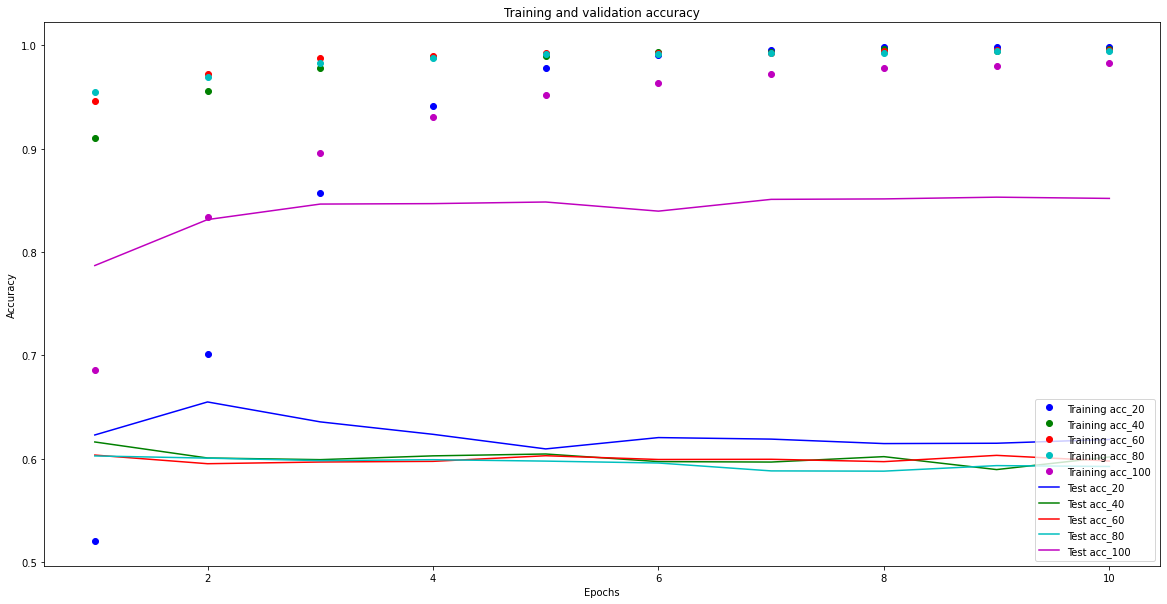

In [32]:
#Plotting the trend of accuracy and validation accuracy in different subsets with different colors to label.
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))

plt.plot(epochs, acc_20, 'bo', label='Training acc_20')
plt.plot(epochs, acc_40, 'go', label='Training acc_40')
plt.plot(epochs, acc_60, 'ro', label='Training acc_60')
plt.plot(epochs, acc_80, 'co', label='Training acc_80')
plt.plot(epochs, acc_100, 'mo', label='Training acc_100')

#b,g,r,c,m
plt.plot(epochs, val_acc_20, 'b', label='Test acc_20')
plt.plot(epochs, val_acc_40, 'g', label='Test acc_40')
plt.plot(epochs, val_acc_60, 'r', label='Test acc_60')
plt.plot(epochs, val_acc_80, 'c', label='Test acc_80')
plt.plot(epochs, val_acc_100, 'm', label='Test acc_100')


plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# **Task 4**

In [33]:
#Show the probability of test dataset
y_pred_prob = CNNbest.predict(test_ds)
y_pred_prob

array([[9.9999583e-01],
       [2.7809715e-06],
       [9.9872500e-01],
       ...,
       [9.9916542e-01],
       [9.9999678e-01],
       [7.9835369e-04]], dtype=float32)

In [34]:
# Transfer the format into dataframe

df = pd.DataFrame(y_pred_prob, columns = ['Probability'])
df


,Probability
0,9.999958e-01
1,2.780971e-06
2,9.987250e-01
3,5.536637e-08
4,9.995911e-01
...,...
24995,9.986387e-01
24996,9.999902e-01
24997,9.991654e-01
24998,9.999968e-01


In [35]:
#Sort the value through probability.
df=df.sort_values(by='Probability', ascending=False)
df

,Probability
15697,1.000000e+00
16502,1.000000e+00
2916,1.000000e+00
16182,1.000000e+00
2929,1.000000e+00
...,...
10086,1.103835e-27
24257,4.622280e-29
387,3.451405e-29
19238,5.296699e-30


In [36]:
#Extracting the 20 most positive text from the first 20 texts
df_pos=df.head(20)
df_pos

,Probability
15697,1.0
16502,1.0
2916,1.0
16182,1.0
2929,1.0
2930,1.0
2935,1.0
16147,1.0
16135,1.0
2944,1.0


In [37]:
#Extracting the 20 most negative text from the last 20 texts

df_neg=df.tail(20)
df_neg

,Probability
2067,3.184291e-23
6618,1.673797e-23
10044,1.509619e-23
23742,1.162567e-23
11081,1.120588e-23
14183,6.056773e-24
3171,3.281499e-24
20399,3.132483e-24
7277,2.101437e-24
758,1.509641e-25


In [38]:
# Get the index of positive text from dataframe 
index_positive = df_pos.index
index_positive

Int64Index([15697, 16502,  2916, 16182,  2929,  2930,  2935, 16147, 16135,
             2944, 16134, 16125, 16098,  2953, 16083, 16082, 16039, 16033,
            16019, 16236],
           dtype='int64')

In [39]:
# Get the index of negative text from dataframe 
index_negative = df_neg.index
index_negative

Int64Index([ 2067,  6618, 10044, 23742, 11081, 14183,  3171, 20399,  7277,
              758,  3973,  2014, 20661,  5201, 23175, 10086, 24257,   387,
            19238,  8896],
           dtype='int64')

In [40]:
# Load the raw test dataset with 1 batch size to get a clear index.
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=1)

Found 25000 files belonging to 2 classes.


In [41]:
# Turn the dataset into a numpy array.
test_df = pd.DataFrame(raw_test_ds)
test_array = test_df.to_numpy()
len(test_array)

25000

In [42]:
#Get the 20 most positive text through the index

pos_review_20 = np.array([])
for i in range(20):
    pos_review_20 = np.concatenate([pos_review_20, test_array[index_positive[i],0]])

pos_review_20

array([b'This is a really mediocre film in the vein of "Buckaroo Banzai." The cast runs around like "Mad Max" wannabes, and they seem to be sharing a joke that they do not want to share with the audience. Wheeler-Nicholson is one of the those guilty pleasure actresses you are delighted to stumble across in films, but she isn\'t worth the price of rental. Space Maggot starts an electrical fire, and burns a vote of 4.',
       b"Sit back and let Director Bharatbala lead us into a visual and sensual voyage of the mind and spirit of India. When was the last time you could say you really enjoyed a movie? This movie has pace and keeps us moving in directions that may only exist in India. If you didn't want to visit India before this movie will surely make you want to visit it now. This movie has dancing girls, a chase scene, and the mafioso involved. But it has a lot more. Thanks, Bharatbala, for taking us on such a spirited and wonderful tale. I loved the ending. We women don't want illusio

In [43]:
#Get the 20 most negative text through the index

neg_review_20 = np.array([])
for i in range(20):
    neg_review_20 = np.concatenate([neg_review_20, test_array[index_negative[i],0]])

neg_review_20

array([b'I really hope the makers of these "movies" read these reviews so that they know that people just dont want their movies. They are just trash and an embarrassment to the killer clown genre of horror. whether or not this was better than the first doesn\'t matter cause theyre both just plain terrible. I\'m surprised they didn\'t learn their lesson from the first movie. Stop Now!! Warning to horror movie watchers, DONT WATCH, RENT OR LOOK AT THE BOXES OF "URBAN" HORROR FILMS, AND ABOVE ALL, DON\'T BUY THEM!!!!',
       b'The Japanese have probably the most sadistic movies around the world,and this is one of the strongest examples.With a running time at about an hour,it contains enough sexual violence and gore to disgust every single sane person on earth(even those who are hunting this type of movies).Three men and a woman are making a porn film.After some normally shots(which are pixelated),the girl is tied up,and the madmen cut her food,arm and tong.After that,they make a hole in

# **Task 5**

In [44]:
# Re-using the dataset from 100% training dataset
train= train_ds_100

In [45]:
# Labeling the good and bad label from the get_vocabulary file with two indexes.
good_label=vectorize_layer.get_vocabulary().index('good')
bad_label=vectorize_layer.get_vocabulary().index('bad')

In [46]:
# Getting the vectorized index
index_with_vectorize=enumerate(vectorize_layer.get_vocabulary())

# Creating the index to word in the dictionary format.
index_word=dict(index_with_vectorize)

# Creating the word to index in the dictionary format which based on "index word".
word_index=dict([(good,bad) for bad, good in index_word.items()])

In [47]:
# Setting the number of max_features, embedding_dims
max_features = 10000

embedding_dim=128

# Creating the series of constants in the lemgth of "word_index"
inputs=tf.constant(range(len(word_index)))

# Inputting those constants into embedding layer.
embed =layers.Embedding(max_features, embedding_dim)(inputs)

In [48]:
# Check the embedding layer in good label.
vector_good = embed[good_label, :]
vector_good

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.03619131,  0.01241191, -0.03796741,  0.00310339,  0.00624271,
       -0.01611952, -0.01798738,  0.00479767, -0.02020401, -0.01466234,
        0.02434136,  0.00349032,  0.03970538, -0.01390172,  0.00067922,
       -0.03205966, -0.0314149 ,  0.04410544, -0.01823934, -0.01363486,
       -0.01383338,  0.00956268,  0.0340086 ,  0.03683797,  0.03495776,
       -0.00958741, -0.03871354,  0.04156895,  0.02649522,  0.03389731,
        0.01858206,  0.03790737,  0.0373745 ,  0.03567329,  0.01263669,
        0.02932662, -0.01530361, -0.00595989, -0.01631676, -0.03275882,
       -0.03555984,  0.00094665, -0.04558162,  0.01373116, -0.03070045,
        0.04661334,  0.02850846,  0.01071107, -0.03190334, -0.02012777,
        0.04268254,  0.04098583,  0.03833834, -0.01516547, -0.0343441 ,
        0.04012593,  0.04155458, -0.01745034,  0.03827704,  0.01040119,
       -0.0305433 ,  0.018913  , -0.00992904,  0.00020283,  0.04144805,
       -0.021277

In [49]:
# Check the embedding layer in bad label.
vector_bad  = embed[bad_label, :]
vector_bad

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 1.73381902e-02, -6.45849854e-03,  1.26160420e-02,  2.30062120e-02,
        1.50952004e-02, -4.89502326e-02, -1.58362463e-03, -7.35282898e-03,
        2.85745300e-02, -3.14587131e-02,  1.22827403e-02, -3.38021070e-02,
        2.29576938e-02,  1.65683366e-02, -4.08790223e-02, -4.48303334e-02,
        2.51858272e-02, -3.38324457e-02, -4.02358882e-02,  3.39149274e-02,
       -3.69586721e-02, -4.56792004e-02, -2.64846925e-02,  2.25424767e-04,
       -3.25725079e-02, -3.17965038e-02, -1.18409395e-02,  4.67177518e-02,
       -1.21045709e-02, -4.53460217e-03, -3.13948765e-02, -3.83286700e-02,
       -4.35113907e-06,  1.33848302e-02, -1.67953745e-02,  1.45389102e-02,
       -1.61330700e-02, -1.92118883e-02, -2.92671844e-03,  7.39378855e-03,
       -8.67878273e-03,  1.89815797e-02, -1.84518918e-02,  1.68566778e-03,
       -4.01995406e-02,  1.06339566e-02, -1.14240535e-02,  6.09353930e-03,
       -2.43318677e-02,  4.90662493e-02, -3.99517901

In [50]:
#Extracting the number of embedding layer size. 
num_embed=embed.shape[0]

In [51]:
#Creating the array in good and bad vectors.

array_good=np.array([vector_good for i in range (num_embed)])

array_bad=np.array([vector_bad for i in range (num_embed)])

#Apping the cosine similarity with embedding layer and different arrays.
similarly_good= tf.keras.losses.cosine_similarity(embed, array_good, axis=1)

similarly_bad= tf.keras.losses.cosine_similarity(embed, array_bad, axis=1)

In [52]:
similarly_good

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([ 0.02278639, -0.1535163 , -0.00747922, ...,  0.04015919,
        0.05306129,  0.04296858], dtype=float32)>

In [53]:
similarly_bad

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([ 0.00213258, -0.03482606, -0.04947995, ..., -0.13809344,
       -0.11409324, -0.09600239], dtype=float32)>

In [54]:
# Extract the best 10 words which are closest to the embeddings for good label.
good_word= np.argsort(np.abs(similarly_good))[:10]
good_word

array([9918, 4677, 2641,  610, 1864,  673, 1477, 6290, 9601, 1905])

In [55]:
# Extract the best 10 words which are closest to the embeddings for bad label.
bad_word= np.argsort(np.abs(similarly_bad))[:10]
bad_word

array([4693, 1320, 6391, 6047, 4847, 5603, 4174, 6279, 2629, 6816])

In [56]:
#Get the 10 words close to good label through the index

for key in good_word:
    print(key, index_word[key])

9918 attributed
4677 crocodile
2641 court
610 ends
1864 witty
673 tells
1477 page
6290 longtime
9601 daft
1905 continues


In [57]:
#Get the 10 words close to badd label through the index

for key in bad_word:
    print(key, index_word[key])

4693 visits
1320 victims
6391 published
6047 blatantly
4847 confidence
5603 furious
4174 charlotte
6279 ol
2629 passing
6816 passage
